Kaggle Competetion-ELO Merchant Category Recommendation

https://www.kaggle.com/c/elo-merchant-category-recommendation

## Online Reference links:
###  Learnt and applied few optimization techniques by referring below links:
#### https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/comment-page-1/
#### https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878
#### https://www.kaggle.com/pavankumarkulkarni/historical-transaction-size-reduction
#### https://chrisalbon.com/machine_learning/linear_regression/adding_interaction_terms/
#### https://zhiyzuo.github.io/Linear-Regression-Diagnostic-in-Python/
 


### Purpose of this file:


    Elo Merchant wants to develop algorithms to identify and serve the most relevant opportunities to individuals, 
    by uncovering signal in customer loyalty.
    
    Inputs derived from machine learning algorithms will improve customers’ lives and help Elo reduce 
    unwanted campaigns, to create the right experience for customers.
    
    Given customer card, transaction and merchant Information, we need to Identify customer loyalty score


### Importing necessary packages


In [1]:
import warnings
import time
import sys
import datetime

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from functools import reduce

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os

from statsmodels.stats.outliers_influence import variance_inflation_factor


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

### Loading train.csv file and performing EDA on this file

In [2]:
train = pd.read_csv('train.csv')
train['first_active_month'] = pd.to_datetime(train['first_active_month'])


In [3]:
train.shape

(201917, 6)

In [4]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [5]:
train.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [6]:
print('Train dataset first_active_month date range : ')
print('----------------------------------------------')
train.first_active_month.agg([np.min, np.max])

Train dataset first_active_month date range : 
----------------------------------------------


amin   2011-11-01
amax   2018-02-01
Name: first_active_month, dtype: datetime64[ns]

### Loading test.csv file and performing EDA on this file

In [7]:
test = pd.read_csv('test.csv')
test['first_active_month'] = pd.to_datetime(test['first_active_month'])


In [8]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [9]:
test.shape

(123623, 5)

In [10]:
test.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [11]:
print('Test dataset first_active_month date range : ')
print('---------------------------------------------')
test.first_active_month.agg([np.min, np.max])

Test dataset first_active_month date range : 
---------------------------------------------


amin   2011-11-01
amax   2018-01-01
Name: first_active_month, dtype: datetime64[ns]

### Correlation matrix for train data
1. We can see from below that feature_1,feature_2 and feature_3 do not have correlation with target (Customer loyalty)
2. So,we need to join other transaction Information to find fields that will help in determining loyalty score

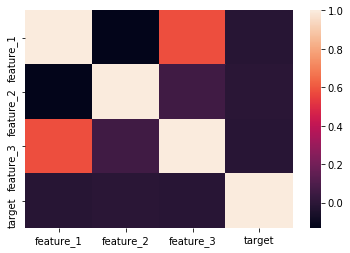

In [12]:
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### first_active_month field trend for train and test data
    We can see from below that first time active card usage has increased over the period and it makes perfect sense

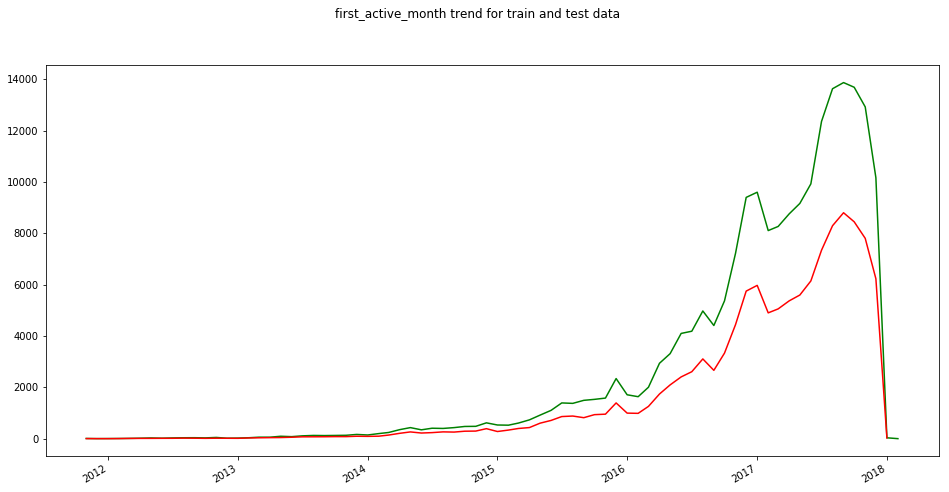

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8));
train['first_active_month'].value_counts().sort_index().plot(color='green')
test['first_active_month'].value_counts().sort_index().plot(color='red')
plt.suptitle('first_active_month trend for train and test data');

### Creating new field to capture number of card active days

In [14]:
train['num_card_active_days_relative'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['num_card_active_days_relative'] = (datetime.date(2018, 1, 1) - test['first_active_month'].dt.date).dt.days

### As we can see below, while the feature data is spread across different values, target value is more or less centered at one point, again indicating no correlation between feature and target fields

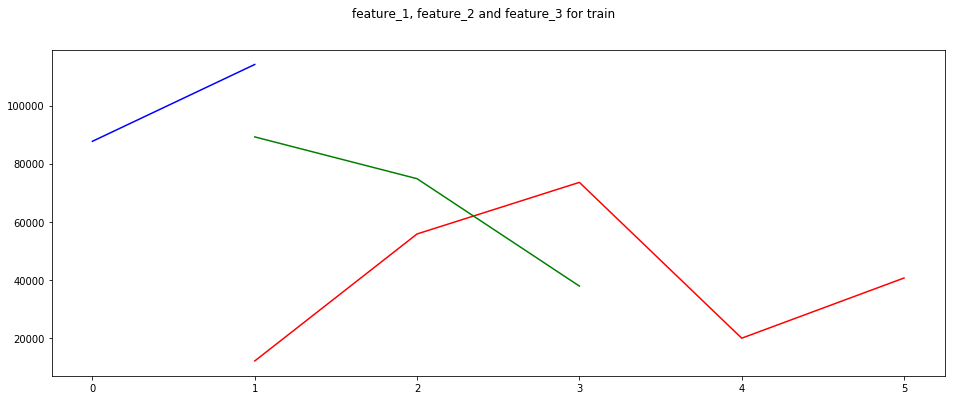

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(color='red')
train['feature_2'].value_counts().sort_index().plot(color='green')
train['feature_3'].value_counts().sort_index().plot(color='blue')
plt.suptitle('feature_1, feature_2 and feature_3 for train');

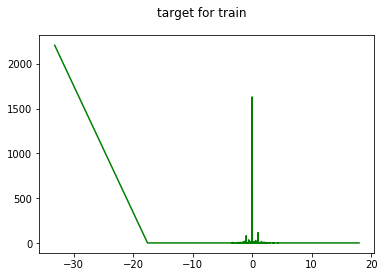

In [16]:
train['target'].value_counts().sort_index().plot(color='green')
plt.suptitle('target for train');

### Loading transaction Information from historical and new merchant transactions file and performing EDA

In [17]:
new_txns = pd.read_csv('new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

hist_txns = pd.read_csv('historical_transactions.csv',
                                     parse_dates=['purchase_date'])

In [18]:
new_txns.shape

(1963031, 14)

In [19]:
hist_txns.shape

(29112361, 14)

### Studying memory usage for transaction file as they are very huge. In further steps, memory optimization techniques are applied

In [20]:
new_txns_mem_onload = new_txns.memory_usage().sum() / 1024**2
hist_txns_mem_onload = hist_txns.memory_usage().sum() / 1024**2

In [21]:
new_txns.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [22]:
print(new_txns['authorized_flag'].value_counts())
print('-----')
print(new_txns.category_1.value_counts())
print('-----')
print(new_txns.category_2.value_counts())
print('-----')
print(new_txns.category_3.value_counts())

Y    1963031
Name: authorized_flag, dtype: int64
-----
N    1899935
Y      63096
Name: category_1, dtype: int64
-----
1.0    1058242
3.0     289525
5.0     259266
4.0     178590
2.0      65663
Name: category_2, dtype: int64
-----
A    922244
B    836178
C    148687
Name: category_3, dtype: int64


### Doing following datatype conversion for memory optimization of new merchant transactions

In [23]:
new_txns['authorized_flag'] = new_txns['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)
new_txns['category_1'] = new_txns['category_1'].apply(lambda x: 1 if x == 'Y' else 0)
new_txns.category_2 = new_txns.category_2.astype('category')
new_txns.category_3 = new_txns.category_3.astype('category')

In [24]:
new_txns.dtypes

authorized_flag                  int64
card_id                         object
city_id                          int64
category_1                       int64
installments                     int64
category_3                    category
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                         int64
subsector_id                     int64
dtype: object

Y    26595452
N     2516909
Name: authorized_flag, dtype: int64
-----
N    27028332
Y     2084029
Name: category_1, dtype: int64
-----
1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64
-----
A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64


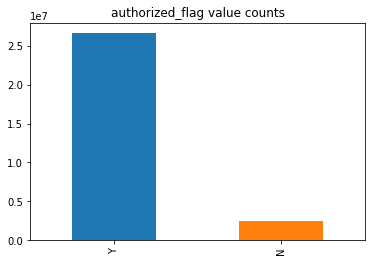

In [25]:
print(hist_txns['authorized_flag'].value_counts())
print('-----')
print(hist_txns.category_1.value_counts())
print('-----')
print(hist_txns.category_2.value_counts())
print('-----')
print(hist_txns.category_3.value_counts())
hist_txns['authorized_flag'].value_counts().plot(kind='bar', title='authorized_flag value counts');

### Doing following datatype conversion for memory optimization of historical transactions

In [26]:
hist_txns['authorized_flag'] = hist_txns['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)
hist_txns['category_1'] = hist_txns['category_1'].apply(lambda x: 1 if x == 'Y' else 0)
hist_txns.category_2 = hist_txns.category_2.astype('category')
hist_txns.category_3 = hist_txns.category_3.astype('category')

In [27]:
hist_txns.shape

(29112361, 14)

In [28]:
new_txns.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [29]:
hist_txns.shape

(29112361, 14)

In [30]:
hist_txns.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [31]:
hist_txns.shape

(29112361, 14)

### Below function is for memory optimization. It downsizes memory allocation based on maximum value for each of the fields. It is invoked later for transactions (historical and new merchant) file data and merchant data

In [32]:
def downsize_numeric_memory_datatypes(dfObj):
    numerics = ['int64', 'float64']
    for col in dfObj.columns:
        col_type = dfObj[col].dtypes
        if col_type in numerics:
            c_min = dfObj[col].min()
            c_max = dfObj[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfObj[col] = dfObj[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfObj[col] = dfObj[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfObj[col] = dfObj[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfObj[col] = dfObj[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfObj[col] = dfObj[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfObj[col] = dfObj[col].astype(np.float32)
                else:
                    dfObj[col] = dfObj[col].astype(np.float64)    
    return dfObj

In [33]:
hist_txns = downsize_numeric_memory_datatypes(hist_txns)
new_txns = downsize_numeric_memory_datatypes(new_txns)

In [34]:
hist_txns.dtypes

authorized_flag                   int8
card_id                         object
city_id                          int16
category_1                        int8
installments                     int16
category_3                    category
merchant_category_id             int16
merchant_id                     object
month_lag                         int8
purchase_amount                float32
purchase_date           datetime64[ns]
category_2                    category
state_id                          int8
subsector_id                      int8
dtype: object

In [35]:
new_txns.dtypes

authorized_flag                   int8
card_id                         object
city_id                          int16
category_1                        int8
installments                     int16
category_3                    category
merchant_category_id             int16
merchant_id                     object
month_lag                         int8
purchase_amount                float16
purchase_date           datetime64[ns]
category_2                    category
state_id                          int8
subsector_id                      int8
dtype: object

### We can see below there are values of -1 and 999 for installments field which do not make sense. Imputing -1 with minimal value of zero. And, Imputing 999 with max installments value i.e.. 12

In [36]:
print(hist_txns['installments'].value_counts().sort_index())

hist_txns['installments'].replace(-1,0,inplace=True)
hist_txns['installments'].replace(999,12,inplace=True)

print(hist_txns['installments'].value_counts().sort_index())


-1        178159
 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
 5        116090
 6        132634
 7         10906
 8         20474
 9          5772
 10       118827
 11          830
 12        55064
 999         188
Name: installments, dtype: int64
0     15589906
1     11677522
2       666416
3       538207
4       179525
5       116090
6       132634
7        10906
8        20474
9         5772
10      118827
11         830
12       55252
Name: installments, dtype: int64


### After above memory optimization techniques, checking for Improvement. 
    We can note below there is 63% memory usage Improvement for historical transactions 
    We can note below there is 65% memory usage Improvement for new merchant transactions 

In [37]:
new_txns_mem_after = new_txns.memory_usage().sum() / 1024**2
hist_txns_mem_after = hist_txns.memory_usage().sum() / 1024**2
hist_imp = 100 * (hist_txns_mem_onload - hist_txns_mem_after) / hist_txns_mem_onload
new_imp = 100 * (new_txns_mem_onload - new_txns_mem_after) / new_txns_mem_onload
print(hist_txns_mem_after, hist_txns_mem_onload, hist_imp)
print(new_txns_mem_after,new_txns_mem_onload, new_imp)

1138.3125162124634 3109.5357055664062 63.39284626400139
73.01196384429932 209.67440795898438 65.17840944204235


In [38]:
hist_txns.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37



hist_txns = pd.get_dummies(hist_txns, columns=['category_2', 'category_3'])
new_txns = pd.get_dummies(new_txns, columns=['category_2', 'category_3'])



In [39]:
hist_txns.head()
hist_txns.shape

(29112361, 14)

In [40]:
new_txns.head()
new_txns.shape

(1963031, 14)

### Concatenating historical and new merchant transactions as they are exactly same in structure

In [41]:
hist_new_txns = pd.concat([hist_txns, new_txns], ignore_index=True)
hist_new_txns.shape

(31075392, 14)

In [42]:
hist_new_txns.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


### Loading Merchants file and calling memory optimization function above

In [43]:
merchants = pd.read_csv('merchants.csv')
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [44]:
merchants = downsize_numeric_memory_datatypes(merchants)
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int32
merchant_category_id           334696 non-null int16
subsector_id                   334696 non-null int8
numerical_1                    334696 non-null float16
numerical_2                    334696 non-null float16
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float32
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int8
avg_sales_lag6                 334683 non-null float32
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int8
avg_sales_lag12                334683 non-null float32
avg_purchases_lag12       

### Concatenating all transactions file with merchant meta data file to create one dataframe constituting 3 files joined Information i.e.. historical_transactions.csv, new_merchant_transactions.csv, merchants.csv

In [45]:
hist_new_txns_merchant_combined=pd.merge(hist_new_txns,merchants, how='left',on=['merchant_id','merchant_category_id','state_id','city_id','subsector_id'] )
hist_new_txns_merchant_combined.head()

,authorized_flag,card_id,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,35.0,23.468750,23.015625,N,A,A,1.08,1.082451,3.0,1.14,1.114135,6.0,1.19,1.156844,12.0,Y,1.0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2084.0,1.092773,-0.057465,N,A,A,1.06,1.052071,3.0,1.06,1.058605,6.0,1.05,1.062087,12.0,Y,1.0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,27369.0,0.021851,0.021851,N,C,C,0.98,0.974653,3.0,0.98,0.967058,6.0,0.97,0.956668,12.0,Y,1.0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,24104.0,-0.057465,-0.057465,N,D,C,1.00,1.053443,3.0,0.88,0.897406,6.0,0.86,0.864394,12.0,Y,1.0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,35.0,23.468750,23.015625,N,A,A,1.08,1.082451,3.0,1.14,1.114135,6.0,1.19,1.156844,12.0,Y,1.0


### We can see below that this merged 3 file dataframe has 4.7 GB of data

In [46]:
hist_new_txns_merchant_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31177723 entries, 0 to 31177722
Data columns (total 31 columns):
authorized_flag                int8
card_id                        object
city_id                        int16
category_1_x                   int8
installments                   int16
category_3                     category
merchant_category_id           int16
merchant_id                    object
month_lag                      int8
purchase_amount                float32
purchase_date                  datetime64[ns]
category_2_x                   category
state_id                       int8
subsector_id                   int8
merchant_group_id              float64
numerical_1                    float16
numerical_2                    float16
category_1_y                   object
most_recent_sales_range        object
most_recent_purchases_range    object
avg_sales_lag3                 float32
avg_purchases_lag3             float64
active_months_lag3             float64
avg_s

### Using below aggregate functions on above combined transaction file Information to create aggregate Information at each card ID level

In [47]:
aggregate = {
    'authorized_flag':['sum'],
    'city_id':'nunique',
    'installments':['sum','mean'],
    'merchant_category_id':'nunique',
    'merchant_id':'nunique',
    'month_lag':['max','min'],
    'purchase_amount':['min','max','mean'],
    'state_id':'nunique',
    'subsector_id':'nunique',
    'avg_sales_lag6':['sum'],
    'avg_purchases_lag6':['sum'],
    'active_months_lag6':['min','max'],
    'avg_sales_lag12':['sum'],
    'avg_purchases_lag12':['sum'],
    'active_months_lag12':['min','max'],
}
hist_new_txns_count = (hist_new_txns_merchant_combined.groupby('card_id').size().to_frame("hist_new_txn_count"))
hist_new_txns_agg=hist_new_txns_merchant_combined.groupby('card_id').agg(aggregate)

In [48]:
hist_new_txns_agg.columns=['authorized_flag_sum','city_id_unique','installments_sum','installments_mean','merchant_category_id_unique','merchant_id_unique','month_lag_max','month_lag_min','purchase_amount_min','purchase_amount_max','purchase_amount_mean','state_id_unique','subsector_id_unique','avg_sales_lag6_sum','avg_purchases_lag6_sum','active_months_lag6_min','active_months_lag6_max','avg_sales_lag12_sum','avg_purchases_lag12_sum','active_months_lag12_min','active_months_lag12_max']

In [49]:
hist_new_txns_agg_count=pd.merge(hist_new_txns_agg,hist_new_txns_count, on='card_id', how='left')
hist_new_txns_agg_count.head()

,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
card_id,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,116.0,5,194,1.284768,19,31,2,-12,-0.728876,1.507069,-0.517706,4,13,44.660000,45.160671,6.0,6.0,43.660000,44.732905,12.0,12.0,151
C_ID_0001238066,146.0,19,243,1.630872,35,90,2,-5,-0.740723,0.768095,-0.585888,6,19,122.510002,125.556963,6.0,6.0,126.320000,128.793608,10.0,12.0,149
C_ID_0001506ef0,64.0,3,1,0.014706,20,29,1,-13,-0.740491,1.493545,-0.530134,2,12,58.939999,60.207676,6.0,6.0,59.450001,61.357861,12.0,12.0,68
C_ID_0001793786,220.0,11,5,0.020243,57,150,2,-9,-0.745405,4.554145,-0.149858,5,25,105.739998,94.739288,6.0,6.0,112.019997,100.258561,10.0,12.0,247
C_ID_000183fdda,148.0,10,284,1.832258,38,84,2,-6,-0.737892,2.764788,-0.486637,7,21,145.319992,135.135017,6.0,6.0,139.089996,132.779927,12.0,12.0,155


In [50]:
hist_new_txns_count.describe()

,hist_new_txn_count
count,325540.000000
mean,95.772326
std,107.952930
min,2.000000
25%,31.000000
50%,60.000000
75%,119.000000
max,5582.000000


In [51]:
hist_new_txns_agg_count.head()

,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
card_id,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,116.0,5,194,1.284768,19,31,2,-12,-0.728876,1.507069,-0.517706,4,13,44.660000,45.160671,6.0,6.0,43.660000,44.732905,12.0,12.0,151
C_ID_0001238066,146.0,19,243,1.630872,35,90,2,-5,-0.740723,0.768095,-0.585888,6,19,122.510002,125.556963,6.0,6.0,126.320000,128.793608,10.0,12.0,149
C_ID_0001506ef0,64.0,3,1,0.014706,20,29,1,-13,-0.740491,1.493545,-0.530134,2,12,58.939999,60.207676,6.0,6.0,59.450001,61.357861,12.0,12.0,68
C_ID_0001793786,220.0,11,5,0.020243,57,150,2,-9,-0.745405,4.554145,-0.149858,5,25,105.739998,94.739288,6.0,6.0,112.019997,100.258561,10.0,12.0,247
C_ID_000183fdda,148.0,10,284,1.832258,38,84,2,-6,-0.737892,2.764788,-0.486637,7,21,145.319992,135.135017,6.0,6.0,139.089996,132.779927,12.0,12.0,155


In [52]:
hist_new_txns_agg_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325540 entries, C_ID_00007093c1 to C_ID_fffffd5772
Data columns (total 22 columns):
authorized_flag_sum            325540 non-null float64
city_id_unique                 325540 non-null int64
installments_sum               325540 non-null int16
installments_mean              325540 non-null float64
merchant_category_id_unique    325540 non-null int64
merchant_id_unique             325540 non-null int64
month_lag_max                  325540 non-null int8
month_lag_min                  325540 non-null int8
purchase_amount_min            325540 non-null float32
purchase_amount_max            325540 non-null float32
purchase_amount_mean           325540 non-null float32
state_id_unique                325540 non-null int64
subsector_id_unique            325540 non-null int64
avg_sales_lag6_sum             325540 non-null float32
avg_purchases_lag6_sum         325540 non-null float64
active_months_lag6_min         312047 non-null float64
active_mo

### Combining above aggregated transaction level Information with train and test card data

In [53]:
train_agg = pd.merge(train, hist_new_txns_agg_count, on='card_id', how='left')
test_agg = pd.merge(test, hist_new_txns_agg_count, on='card_id', how='left')

In [54]:
train_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 29 columns):
first_active_month               201917 non-null datetime64[ns]
card_id                          201917 non-null object
feature_1                        201917 non-null int64
feature_2                        201917 non-null int64
feature_3                        201917 non-null int64
target                           201917 non-null float64
num_card_active_days_relative    201917 non-null int64
authorized_flag_sum              201917 non-null float64
city_id_unique                   201917 non-null int64
installments_sum                 201917 non-null int16
installments_mean                201917 non-null float64
merchant_category_id_unique      201917 non-null int64
merchant_id_unique               201917 non-null int64
month_lag_max                    201917 non-null int8
month_lag_min                    201917 non-null int8
purchase_amount_min              201917 non-null f

In [55]:
train_agg.head()


,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_card_active_days_relative,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,270.0,9,4,0.014134,46,117,2,-8,-0.739395,2.258394,-0.633260,3,21,347.019989,323.432920,5.0,6.0,426.970001,380.007243,5.0,12.0,283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,348.0,9,581,1.618384,58,148,2,-12,-0.742400,4.630300,-0.599997,3,24,314.450012,324.914958,6.0,6.0,327.869995,354.221205,10.0,12.0,359
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,42.0,5,0,0.000000,9,14,2,-13,-0.730138,-0.145847,-0.678809,2,8,40.829998,41.806657,6.0,6.0,41.020000,42.214959,10.0,12.0,44
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153,86.0,7,93,1.081395,28,57,2,-5,-0.740897,1.445596,-0.646131,5,15,68.919998,70.201463,6.0,6.0,69.669998,70.984917,9.0,12.0,86
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92,165.0,7,218,1.282353,37,102,2,-3,-0.746156,7.193041,-0.407573,7,19,294.690002,162.208828,5.0,6.0,299.100006,167.054901,5.0,12.0,170


In [56]:
test_agg.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,num_card_active_days_relative,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,275.0,47.0,7,146,2.056338,17,27,2,-8,-0.743903,0.235676,-0.598748,3,13,58.829998,46.668569,6.0,6.0,56.889999,45.513602,12.0,12.0,71
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,365.0,86.0,4,94,1.080460,22,36,2,-13,-0.740723,0.318817,-0.633113,3,15,3.940000,3.977055,6.0,6.0,3.800000,3.817716,12.0,12.0,87
2,2017-08-01,C_ID_b709037bc5,5,1,1,153.0,11.0,4,58,3.866667,9,11,1,-6,-0.724609,2.525867,0.313902,5,7,6.470000,7.381278,6.0,6.0,6.250000,7.404296,12.0,12.0,15
3,2017-12-01,C_ID_d27d835a9f,2,1,0,31.0,36.0,3,69,1.916667,25,33,2,-2,-0.731881,0.087965,-0.539864,3,14,29.860001,31.203087,6.0,6.0,31.600000,32.696872,12.0,12.0,36
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,762.0,93.0,5,125,1.077586,33,53,2,-13,-0.746758,15.782255,0.320740,4,15,265.549988,245.001830,6.0,6.0,305.760010,272.655103,7.0,12.0,116


### Plotting correlation matrix for train aggregated data file

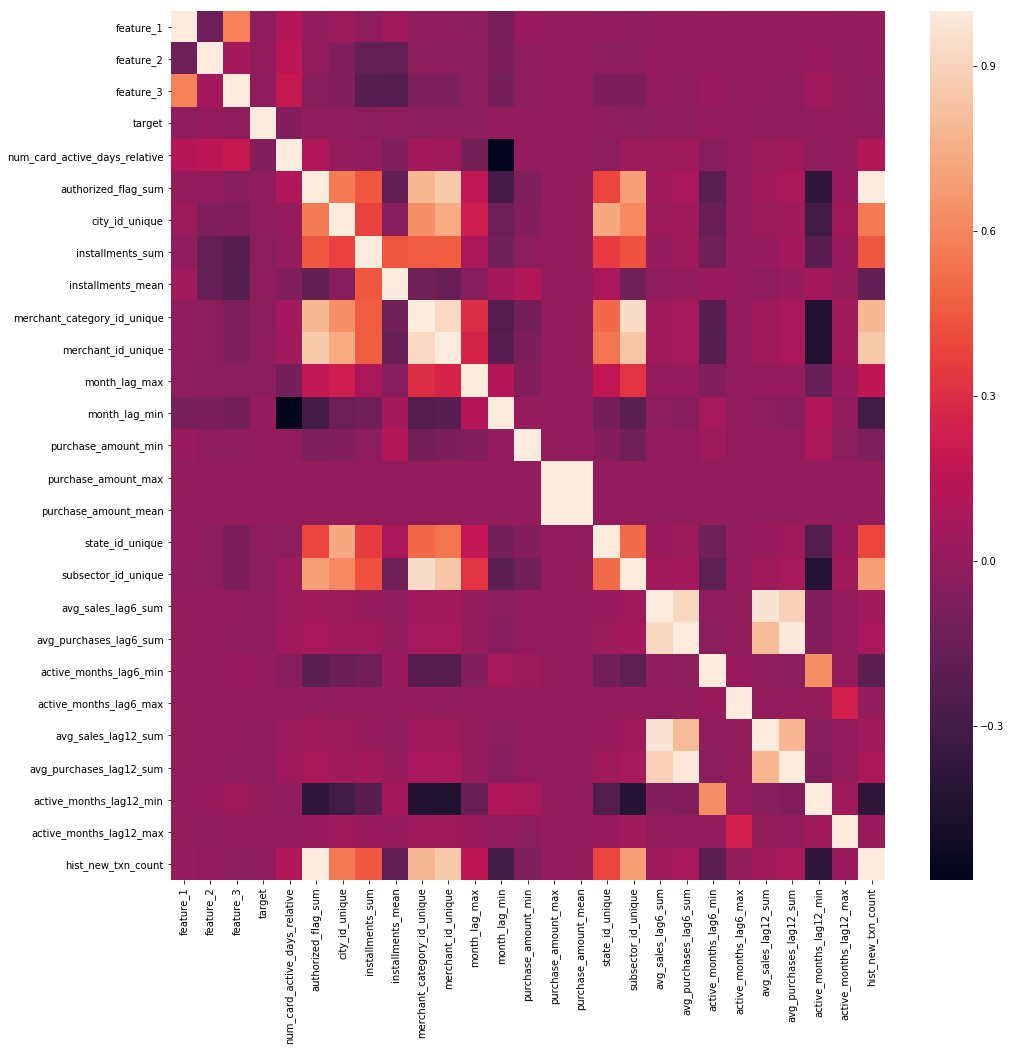

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (16, 16));


corr = train_agg.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [58]:
corr_matrix = train_agg.corr()
corr_matrix["target"].sort_values(ascending=False)

target                           1.000000
active_months_lag6_min           0.006074
active_months_lag12_min          0.005135
purchase_amount_min              0.004772
month_lag_min                    0.001677
purchase_amount_mean             0.000303
purchase_amount_max              0.000098
active_months_lag6_max          -0.000446
active_months_lag12_max         -0.003843
feature_2                       -0.006242
avg_sales_lag12_sum             -0.006796
avg_sales_lag6_sum              -0.007908
feature_3                       -0.008125
avg_purchases_lag6_sum          -0.009322
avg_purchases_lag12_sum         -0.009491
authorized_flag_sum             -0.009516
city_id_unique                  -0.013746
feature_1                       -0.014251
hist_new_txn_count              -0.014411
merchant_id_unique              -0.016967
installments_mean               -0.017728
state_id_unique                 -0.018634
month_lag_max                   -0.022563
merchant_category_id_unique     -0

### Allocating target column Information to Y_Var variable and removing target from train

In [59]:
Y_var=train_agg['target']
del train_agg['target']

In [60]:
Y_var.head()

0   -0.820283
1    0.392913
2    0.688056
3    0.142495
4   -0.159749
Name: target, dtype: float64

In [61]:
Y_var = pd.DataFrame(data=Y_var.values, columns=['target'])

### Creating X_var variables with columns of interest from train_agg file

In [62]:
X_var=train_agg.filter(['first_active_month','card_id','feature_1','feature_2','feature_3','authorized_flag_sum','city_id_unique','installments_sum','installments_mean','merchant_category_id_unique','merchant_id_unique','month_lag_max','month_lag_min','purchase_amount_min','purchase_amount_max','purchase_amount_mean','state_id_unique','subsector_id_unique','txn_count','avg_sales_lag6_sum','avg_purchases_lag6_sum','active_months_lag6_min','active_months_lag6_max','avg_sales_lag12_sum','avg_purchases_lag12_sum','active_months_lag12_min','active_months_lag12_max','hist_new_txn_count'], axis=1)

In [63]:
X_var.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
0,2017-06-01,C_ID_92a2005557,5,2,1,270.0,9,4,0.014134,46,117,2,-8,-0.739395,2.258394,-0.633260,3,21,347.019989,323.432920,5.0,6.0,426.970001,380.007243,5.0,12.0,283
1,2017-01-01,C_ID_3d0044924f,4,1,0,348.0,9,581,1.618384,58,148,2,-12,-0.742400,4.630300,-0.599997,3,24,314.450012,324.914958,6.0,6.0,327.869995,354.221205,10.0,12.0,359
2,2016-08-01,C_ID_d639edf6cd,2,2,0,42.0,5,0,0.000000,9,14,2,-13,-0.730138,-0.145847,-0.678809,2,8,40.829998,41.806657,6.0,6.0,41.020000,42.214959,10.0,12.0,44
3,2017-09-01,C_ID_186d6a6901,4,3,0,86.0,7,93,1.081395,28,57,2,-5,-0.740897,1.445596,-0.646131,5,15,68.919998,70.201463,6.0,6.0,69.669998,70.984917,9.0,12.0,86
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,165.0,7,218,1.282353,37,102,2,-3,-0.746156,7.193041,-0.407573,7,19,294.690002,162.208828,5.0,6.0,299.100006,167.054901,5.0,12.0,170


### Doing transformation for fields card_id and first_active_month

In [64]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_var['card_id'] = le.fit_transform(X_var['card_id'])

In [65]:
X_var['first_active_month'] = le.fit_transform(X_var['first_active_month'])

In [66]:
print(X_var.isnull().values.any())
print(Y_var.isnull().values.any())

True
False


In [67]:
#We can see that the columns avg sales, purchages and active months have nas and hance we replace the values with zeros to remove thier weitage in the model
X_var.isna().any()

first_active_month             False
card_id                        False
feature_1                      False
feature_2                      False
feature_3                      False
authorized_flag_sum            False
city_id_unique                 False
installments_sum               False
installments_mean              False
merchant_category_id_unique    False
merchant_id_unique             False
month_lag_max                  False
month_lag_min                  False
purchase_amount_min            False
purchase_amount_max            False
purchase_amount_mean           False
state_id_unique                False
subsector_id_unique            False
avg_sales_lag6_sum             False
avg_purchases_lag6_sum         False
active_months_lag6_min          True
active_months_lag6_max          True
avg_sales_lag12_sum            False
avg_purchases_lag12_sum        False
active_months_lag12_min         True
active_months_lag12_max         True
hist_new_txn_count             False
d

In [68]:
X_var.fillna(0,inplace=True)

In [69]:
#The null values have been replaced
print(X_var.isnull().values.any())
print(Y_var.isnull().values.any())

False
False


In [70]:
X_var.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 27 columns):
first_active_month             201917 non-null int64
card_id                        201917 non-null int64
feature_1                      201917 non-null int64
feature_2                      201917 non-null int64
feature_3                      201917 non-null int64
authorized_flag_sum            201917 non-null float64
city_id_unique                 201917 non-null int64
installments_sum               201917 non-null int16
installments_mean              201917 non-null float64
merchant_category_id_unique    201917 non-null int64
merchant_id_unique             201917 non-null int64
month_lag_max                  201917 non-null int8
month_lag_min                  201917 non-null int8
purchase_amount_min            201917 non-null float32
purchase_amount_max            201917 non-null float32
purchase_amount_mean           201917 non-null float32
state_id_unique                20

### Splitting train aggregated data above to train and test 

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X_var, Y_var, test_size=0.3)

In [72]:
X_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
133942,66,74457,3,2,1,51.0,3,9,0.136364,25,37,2,-4,-0.745405,0.297435,-0.631752,3,15,67.209999,61.206634,6.0,6.0,67.550003,61.467583,12.0,12.0,66
69090,70,176951,2,3,0,17.0,3,22,1.100000,9,11,0,-4,-0.664277,0.649055,-0.523712,3,6,16.870001,17.922649,6.0,6.0,16.830000,18.569500,12.0,12.0,20
89090,58,50382,3,2,1,67.0,10,3,0.040000,27,48,2,-13,-0.743437,-0.018588,-0.627520,7,19,49.340000,50.012200,6.0,6.0,49.299999,50.671878,12.0,12.0,75
58875,59,153571,5,1,1,91.0,3,274,2.302521,8,12,2,-12,-0.734887,4.035295,-0.170311,2,7,43.980000,3485.326946,6.0,6.0,41.560001,5287.701644,7.0,12.0,119
137597,64,103328,3,2,1,27.0,1,0,0.000000,9,13,2,-10,-0.746232,-0.437362,-0.703105,1,7,30.629999,29.639196,6.0,6.0,31.199999,30.774409,12.0,12.0,28


In [73]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141341 entries, 133942 to 166482
Data columns (total 27 columns):
first_active_month             141341 non-null int64
card_id                        141341 non-null int64
feature_1                      141341 non-null int64
feature_2                      141341 non-null int64
feature_3                      141341 non-null int64
authorized_flag_sum            141341 non-null float64
city_id_unique                 141341 non-null int64
installments_sum               141341 non-null int16
installments_mean              141341 non-null float64
merchant_category_id_unique    141341 non-null int64
merchant_id_unique             141341 non-null int64
month_lag_max                  141341 non-null int8
month_lag_min                  141341 non-null int8
purchase_amount_min            141341 non-null float32
purchase_amount_max            141341 non-null float32
purchase_amount_mean           141341 non-null float32
state_id_unique             

In [74]:
print(X_train.isnull().values.any())
print(Y_train.isnull().values.any())

False
False


### Performing Inf replacement with 0 for cases where it might be inf during aggregation function

In [75]:
X_train.replace(np.inf,0,inplace=True)
X_train.replace(np.inf,0,inplace=True)
Y_train.replace(-np.inf,0,inplace=True)
Y_train.replace(np.inf,0,inplace=True)
X_test.replace(np.inf,0,inplace=True)
X_test.replace(np.inf,0,inplace=True)
Y_test.replace(-np.inf,0,inplace=True)
Y_test.replace(np.inf,0,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


### Performing Linear Regression for Train data

In [76]:
regress = LinearRegression()

In [77]:
regress.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [78]:
Y_predict = regress.predict(X_test)
print('Linear Regression R squared": %.4f' % regress.score(X_test, Y_test))

Linear Regression R squared": 0.0081


In [79]:
regression_mean_sq_err = mean_squared_error(Y_predict, Y_test)
regression_mean_sq_err = np.sqrt(regression_mean_sq_err)
print('Linear Regression RMSE: %.4f' % regression_mean_sq_err)

Linear Regression RMSE: 3.8319


## We can Infer from below plot that linear model assumption of residuals randomness is not met

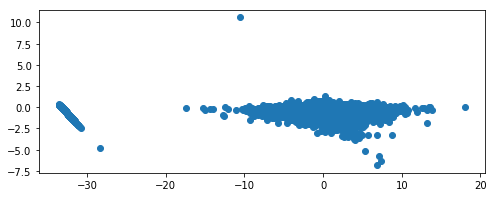

In [80]:
residual_lr=Y_test-Y_predict
fig, ax = plt.subplots(figsize=(8,3))
_ = ax.scatter(residual_lr, Y_predict)

## Performing Breusch-Pagan test below to check homoskedasticity

In [81]:
import statsmodels.stats.diagnostic
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual_lr,X_test)

## We can Infer from below low p-value that linear model homoskedasticity assumption is not met

In [82]:
print(pval, f_pval)

0.0 0.0


## We can Infer from below plot that linear model assumption of normal QQplot is not met

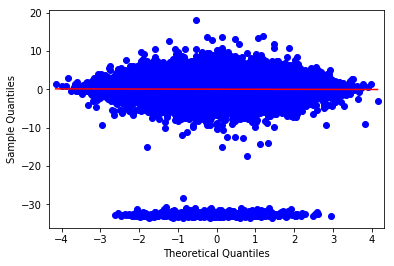

In [83]:
import statsmodels.api as sm
fig = sm.qqplot(residual_lr, line = 'r')

### Performing Gradient Boosting Regression for Train data

In [84]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [85]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, Y_test))

Gradient Boosting R squared": 0.0336


In [86]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, Y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 3.7823


### Calculating VIF to Identify and remove fields that cause variance inflation factor

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(x):
    thresh = 5.0
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        print("Iteration no.")
        print(i)
        print(vif)
        a = np.argmax(vif)
        print("Max VIF is for variable no.:")
        print(a)
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)
X_train_out = calculate_vif(X_train) 



Iteration no.
1
[53.62904619589219, 3.96593849963104, 12.806263859839977, 6.848381620119491, 4.147287959815594, 159.19063460236035, 11.200666721170029, 2.9441277323193686, 3.1062440986366266, 70.01161212879727, 33.255659682987904, 6.145607889135694, 8.057626359443677, 108.1800993689001, 187.8414331119462, 187.83803025067178, 9.821367343016023, 64.04623628138452, 827.4392076511178, 963.6281567057226, 168.2358616877735, 3121.3556048304768, 328.9294680837995, 387.56615578460145, 38.98237058769298, 2977.636997655202, 156.81064277575152]
Max VIF is for variable no.:
21
Iteration no.
2
[53.611003672708335, 3.9659276532017507, 12.804615593372185, 6.848066374202432, 4.146968904612538, 159.17549823402865, 11.199558910464887, 2.944048674012491, 3.105789852392084, 70.00377160314423, 33.255395376794304, 6.145590812582539, 8.054225271561094, 108.0988899053589, 187.84123003344575, 187.83782813347432, 9.820661987944595, 64.0363614046881, 827.4382851346128, 963.6281545842749, 159.8337615057626, 328.92

### X_train_out below has reduced fields by removing fields that cause high VIF above

In [88]:
X_train_out.head()


,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,74457,2,1,3,9,0.136364,2,-0.631752,67.550003,61.467583,66
69090,176951,3,0,3,22,1.100000,0,-0.523712,16.830000,18.569500,20
89090,50382,2,1,10,3,0.040000,2,-0.627520,49.299999,50.671878,75
58875,153571,1,1,3,274,2.302521,2,-0.170311,41.560001,5287.701644,119
137597,103328,2,1,1,0,0.000000,2,-0.703105,31.199999,30.774409,28


### Performing Linear Regression with reduced VIF fields below

In [89]:
regress_vif = LinearRegression()
regress_vif.fit(X_train_out, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [94]:
X_test_out=X_test.filter(['card_id','feature_2','feature_3','city_id_unique','installments_sum','installments_mean','month_lag_max','purchase_amount_mean','avg_sales_lag12_sum','avg_purchases_lag12_sum','hist_new_txn_count'],axis=1)

In [95]:
X_test_out.head()

,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
143981,192919,2,1,14,5,0.009346,2,-0.589840,689996.937500,50656.892925,535
12334,26092,3,1,4,103,1.061856,2,-0.676915,88.430000,87.716701,97
126244,178447,1,0,6,124,1.107143,2,-0.566897,83.659996,89.990997,112
123127,16377,1,0,4,46,2.421053,2,-0.440258,4.170000,4.432076,19
111254,83166,3,1,5,58,3.222222,2,-0.383769,4.710000,4.830242,18


In [96]:
print(X_test.info())
print(X_test_out.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60576 entries, 143981 to 93234
Data columns (total 27 columns):
first_active_month             60576 non-null int64
card_id                        60576 non-null int64
feature_1                      60576 non-null int64
feature_2                      60576 non-null int64
feature_3                      60576 non-null int64
authorized_flag_sum            60576 non-null float64
city_id_unique                 60576 non-null int64
installments_sum               60576 non-null int64
installments_mean              60576 non-null float64
merchant_category_id_unique    60576 non-null int64
merchant_id_unique             60576 non-null int64
month_lag_max                  60576 non-null int64
month_lag_min                  60576 non-null int64
purchase_amount_min            60576 non-null float32
purchase_amount_max            60576 non-null float32
purchase_amount_mean           60576 non-null float32
state_id_unique                60576 non-nul

In [97]:
Y_predict = regress_vif.predict(X_test_out)

In [98]:
print('Linear Regression R squared": %.4f' % regress_vif.score(X_test_out, Y_test))

Linear Regression R squared": 0.0022


In [99]:
regression_mean_sq_err = mean_squared_error(Y_predict, Y_test)
regression_mean_sq_err = np.sqrt(regression_mean_sq_err)
print('Linear Regression RMSE: %.4f' % regression_mean_sq_err)


Linear Regression RMSE: 3.8433


In [100]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regress_vif,X_train_out,Y_train,scoring="neg_mean_squared_error",cv=10)
rmse_scores = np.sqrt(-scores)

In [101]:
rmse_scores

array([3.86169555, 3.71394699, 4.07687269, 3.81846371, 3.96180751,
       3.82216035, 3.79324955, 3.77033771, 3.8020359 , 3.93793982])

In [102]:
np.mean(rmse_scores)

3.855850978423232

### Performing Gradient Boosting Regression with reduced VIF fields below

In [103]:
gradient_model = ensemble.GradientBoostingRegressor()
gradient_model.fit(X_train_out, Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
print('Gradient Boosting R squared": %.4f' % gradient_model.score(X_test_out, Y_test))

Gradient Boosting R squared": 0.0067


In [105]:
Y_gradient_predict = gradient_model.predict(X_test_out)
model_mse_gradient = mean_squared_error(Y_gradient_predict, Y_test)
model_rmse_gradient = np.sqrt(model_mse_gradient)
print('Gradient Boosting RMSE: %.4f' % model_rmse_gradient)

Gradient Boosting RMSE: 3.8346


## Kaggle Output for linear regression with gradient boosting regression algorithm


In [106]:
del test_agg['num_card_active_days_relative']
test_agg.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_sum,city_id_unique,installments_sum,installments_mean,merchant_category_id_unique,merchant_id_unique,month_lag_max,month_lag_min,purchase_amount_min,purchase_amount_max,purchase_amount_mean,state_id_unique,subsector_id_unique,avg_sales_lag6_sum,avg_purchases_lag6_sum,active_months_lag6_min,active_months_lag6_max,avg_sales_lag12_sum,avg_purchases_lag12_sum,active_months_lag12_min,active_months_lag12_max,hist_new_txn_count
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,47.0,7,146,2.056338,17,27,2,-8,-0.743903,0.235676,-0.598748,3,13,58.829998,46.668569,6.0,6.0,56.889999,45.513602,12.0,12.0,71
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,86.0,4,94,1.080460,22,36,2,-13,-0.740723,0.318817,-0.633113,3,15,3.940000,3.977055,6.0,6.0,3.800000,3.817716,12.0,12.0,87
2,2017-08-01,C_ID_b709037bc5,5,1,1,11.0,4,58,3.866667,9,11,1,-6,-0.724609,2.525867,0.313902,5,7,6.470000,7.381278,6.0,6.0,6.250000,7.404296,12.0,12.0,15
3,2017-12-01,C_ID_d27d835a9f,2,1,0,36.0,3,69,1.916667,25,33,2,-2,-0.731881,0.087965,-0.539864,3,14,29.860001,31.203087,6.0,6.0,31.600000,32.696872,12.0,12.0,36
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,93.0,5,125,1.077586,33,53,2,-13,-0.746758,15.782255,0.320740,4,15,265.549988,245.001830,6.0,6.0,305.760010,272.655103,7.0,12.0,116


In [117]:
X_test_var= pd.DataFrame([test_agg.card_id, test_agg.feature_2,test_agg.feature_3,test_agg.city_id_unique,test_agg.installments_sum,test_agg.installments_mean,test_agg.month_lag_max,test_agg.purchase_amount_mean,test_agg.hist_new_txn_count,test_agg.avg_sales_lag12_sum,test_agg.avg_purchases_lag12_sum]).transpose()

In [118]:
X_test_var.head()


,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,hist_new_txn_count,avg_sales_lag12_sum,avg_purchases_lag12_sum
0,C_ID_0ab67a22ab,3,1,7,146,2.05634,2,-0.598748,71,56.89,45.5136
1,C_ID_130fd0cbdd,3,0,4,94,1.08046,2,-0.633113,87,3.8,3.81772
2,C_ID_b709037bc5,1,1,4,58,3.86667,1,0.313902,15,6.25,7.4043
3,C_ID_d27d835a9f,1,0,3,69,1.91667,2,-0.539864,36,31.6,32.6969
4,C_ID_2b5e3df5c2,1,1,5,125,1.07759,2,0.32074,116,305.76,272.655


In [119]:
X_test_var_card_id=X_test_var.filter(['card_id'])

In [120]:
X_test_var_card_id.head()

,card_id
0,C_ID_0ab67a22ab
1,C_ID_130fd0cbdd
2,C_ID_b709037bc5
3,C_ID_d27d835a9f
4,C_ID_2b5e3df5c2


In [121]:
X_test_var.isna().any()

card_id                    False
feature_2                  False
feature_3                  False
city_id_unique             False
installments_sum           False
installments_mean          False
month_lag_max              False
purchase_amount_mean       False
hist_new_txn_count         False
avg_sales_lag12_sum        False
avg_purchases_lag12_sum    False
dtype: bool

In [122]:
X_test_var.fillna(0,inplace=True)

In [123]:
print(X_test_var.isnull().values.any())

False


In [124]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_test_var['card_id'] = le.fit_transform(X_test_var['card_id'])



##Fitting the testdata on models for predcition

In [125]:
X_test_var.replace(np.inf,0,inplace=True)
X_test_var.replace(-np.inf,0,inplace=True)

In [126]:
Y_predict_test = regress_vif.predict(X_test_var)

In [127]:
Y_predict_test_=pd.DataFrame(Y_predict_test)



In [128]:
Y_predict_test_.columns=['target']

In [129]:
Y_predict_test_.head()

,target
0,-0.692274
1,-0.472982
2,-0.459693
3,-0.372257
4,-0.503964


In [130]:
X_test_var_card_id.head()

,card_id
0,C_ID_0ab67a22ab
1,C_ID_130fd0cbdd
2,C_ID_b709037bc5
3,C_ID_d27d835a9f
4,C_ID_2b5e3df5c2


In [131]:
Kaggel_output_test=pd.concat([X_test_var_card_id,Y_predict_test_],axis=1)

In [132]:
Kaggel_output_test.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.692274
1,C_ID_130fd0cbdd,-0.472982
2,C_ID_b709037bc5,-0.459693
3,C_ID_d27d835a9f,-0.372257
4,C_ID_2b5e3df5c2,-0.503964


In [133]:
Kaggel_output_test.to_csv('Kaggle_test.csv')

## Gradient model to predict without removing VIF significant columns


In [134]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,num_card_active_days_relative
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,275.0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,365.0
2,2017-08-01,C_ID_b709037bc5,5,1,1,153.0
3,2017-12-01,C_ID_d27d835a9f,2,1,0,31.0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,762.0


In [135]:
test_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Data columns (total 27 columns):
first_active_month             123622 non-null datetime64[ns]
card_id                        123623 non-null object
feature_1                      123623 non-null int64
feature_2                      123623 non-null int64
feature_3                      123623 non-null int64
authorized_flag_sum            123623 non-null float64
city_id_unique                 123623 non-null int64
installments_sum               123623 non-null int16
installments_mean              123623 non-null float64
merchant_category_id_unique    123623 non-null int64
merchant_id_unique             123623 non-null int64
month_lag_max                  123623 non-null int8
month_lag_min                  123623 non-null int8
purchase_amount_min            123623 non-null float32
purchase_amount_max            123623 non-null float32
purchase_amount_mean           123623 non-null float32
state_id_unique        

In [136]:
train_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 28 columns):
first_active_month               201917 non-null datetime64[ns]
card_id                          201917 non-null object
feature_1                        201917 non-null int64
feature_2                        201917 non-null int64
feature_3                        201917 non-null int64
num_card_active_days_relative    201917 non-null int64
authorized_flag_sum              201917 non-null float64
city_id_unique                   201917 non-null int64
installments_sum                 201917 non-null int16
installments_mean                201917 non-null float64
merchant_category_id_unique      201917 non-null int64
merchant_id_unique               201917 non-null int64
month_lag_max                    201917 non-null int8
month_lag_min                    201917 non-null int8
purchase_amount_min              201917 non-null float32
purchase_amount_max              201917 non-null f

In [137]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
test_agg['card_id'] = le.fit_transform(test_agg['card_id'])
test_agg['first_active_month'] = le.fit_transform(test_agg['first_active_month'])

In [138]:
np.isinf(test_agg.values.any())

False

In [139]:
test_agg.fillna(0,inplace=True)

In [140]:
(np.isnan(test_agg).values.any())

False

In [142]:
test_agg.replace(-np.inf,0,inplace=True)
test_agg.replace(np.inf,0,inplace=True)

In [143]:
Y_predict_test_WithoutVIF = model.predict(test_agg)

In [144]:
Y_predict_test_WOVIF=pd.DataFrame(Y_predict_test_WithoutVIF)
Y_predict_test_WOVIF.columns=['target']

In [145]:
Y_predict_test_WOVIF.tail()

,target
123618,0.912648
123619,0.334420
123620,-1.616371
123621,-1.065102
123622,-0.071603


In [146]:
Kaggel_output_test_WO_VIF=pd.concat([X_test_var_card_id,Y_predict_test_WOVIF],axis=1)

In [147]:
Kaggel_output_test_WO_VIF.tail()

,card_id,target
123618,C_ID_7a239d2eda,0.912648
123619,C_ID_75ace375ae,0.334420
123620,C_ID_21d56d950c,-1.616371
123621,C_ID_6c46fc5a9d,-1.065102
123622,C_ID_87e7979a5f,-0.071603


In [148]:
Kaggel_output_test_WO_VIF.to_csv('Kaggle_test_Without_VIF.csv')

## Interactions to check the model performance after removing the VIF columns with two degrees

In [149]:
from sklearn.preprocessing import PolynomialFeatures

In [150]:
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_int_two_degree_train = interaction.fit_transform(X_train_out)

In [151]:
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_int_two_degree = interaction.fit_transform(X_test_out)

In [152]:
X_int_two_degree=pd.DataFrame(X_int_two_degree)

In [153]:
regress_interaction_train = LinearRegression()
regress_interaction_train.fit(X_train_out, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [154]:
print('Linear Regression R squared": %.4f' % regress_interaction_train.score(X_test_out, Y_test))

Linear Regression R squared": 0.0022


In [155]:
Y_predict_interaction = regress_interaction_train.predict(X_test_out)

In [156]:
regression_mean_sq_err = mean_squared_error(Y_predict_interaction, Y_test)
regression_mean_sq_err = np.sqrt(regression_mean_sq_err)
print('Linear Regression RMSE: %.4f' % regression_mean_sq_err)

Linear Regression RMSE: 3.8433


## Applying Transformation (Square Root) to check Model Performance

In [157]:
X_train_out_sqroot=X_train_out
X_train_out_sqroot.head()

,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,74457,2,1,3,9,0.136364,2,-0.631752,67.550003,61.467583,66
69090,176951,3,0,3,22,1.100000,0,-0.523712,16.830000,18.569500,20
89090,50382,2,1,10,3,0.040000,2,-0.627520,49.299999,50.671878,75
58875,153571,1,1,3,274,2.302521,2,-0.170311,41.560001,5287.701644,119
137597,103328,2,1,1,0,0.000000,2,-0.703105,31.199999,30.774409,28


In [158]:
X_train_out_sqroot.applymap(np.sqrt)
X_train_out_sqroot.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6070: RuntimeWarning: invalid value encountered in sqrt
  return lib.map_infer(x.astype(object).values, func)


,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,74457,2,1,3,9,0.136364,2,-0.631752,67.550003,61.467583,66
69090,176951,3,0,3,22,1.100000,0,-0.523712,16.830000,18.569500,20
89090,50382,2,1,10,3,0.040000,2,-0.627520,49.299999,50.671878,75
58875,153571,1,1,3,274,2.302521,2,-0.170311,41.560001,5287.701644,119
137597,103328,2,1,1,0,0.000000,2,-0.703105,31.199999,30.774409,28


In [159]:
X_train_out_sqroot.fillna(0,inplace=True)

In [160]:
X_test_out_sqroot=X_test_out
X_test_out_sqroot.fillna(0,inplace=True)

In [161]:
gradient_model_transformation = ensemble.GradientBoostingRegressor()
gradient_model_transformation.fit(X_train_out_sqroot, Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [162]:
print('Gradient Boosting R squared": %.4f' % gradient_model.score(X_test_out_sqroot, Y_test))

Gradient Boosting R squared": 0.0067


In [163]:
Y_gradient_predict_sqroot = gradient_model.predict(X_test_out_sqroot)
model_mse_gradient_sqroot = mean_squared_error(Y_gradient_predict_sqroot, Y_test)
model_mse_gradient_sqroot = np.sqrt(model_mse_gradient_sqroot)
print('Gradient Boosting RMSE: %.4f' % model_mse_gradient_sqroot)

Gradient Boosting RMSE: 3.8346


## Applying Transformation (Log) to check Model Performance

In [164]:
X_train_out_log=X_train_out
X_train_out_log.head()

,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,74457,2,1,3,9,0.136364,2,-0.631752,67.550003,61.467583,66
69090,176951,3,0,3,22,1.100000,0,-0.523712,16.830000,18.569500,20
89090,50382,2,1,10,3,0.040000,2,-0.627520,49.299999,50.671878,75
58875,153571,1,1,3,274,2.302521,2,-0.170311,41.560001,5287.701644,119
137597,103328,2,1,1,0,0.000000,2,-0.703105,31.199999,30.774409,28


In [165]:
col =X_train_out_log.columns
for i in col:
    X_train_out_log[i]=np.log(X_train_out_log[i])
X_train_out_log.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,11.217977,0.693147,0.000000,1.098612,2.197225,-1.992430,0.693147,NaN,4.212868,4.118510,4.189655
69090,12.083628,1.098612,-inf,1.098612,3.091042,0.095310,-inf,NaN,2.823163,2.921520,2.995732
89090,10.827389,0.693147,0.000000,2.302585,1.098612,-3.218876,0.693147,NaN,3.897924,3.925371,4.317488
58875,11.941918,0.000000,0.000000,1.098612,5.613128,0.834005,0.693147,NaN,3.727138,8.573139,4.779123
137597,11.545664,0.693147,0.000000,0.000000,-inf,-inf,0.693147,NaN,3.440418,3.426683,3.332205


In [166]:
X_train_out_log.fillna(0,inplace=True)

In [167]:
X_train_out_log.replace(np.inf,0)

,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,11.217977,0.693147,0.000000,1.098612,2.197225,-1.992430,0.693147,0.000000,4.212868,4.118510,4.189655
69090,12.083628,1.098612,-inf,1.098612,3.091042,0.095310,-inf,0.000000,2.823163,2.921520,2.995732
89090,10.827389,0.693147,0.000000,2.302585,1.098612,-3.218876,0.693147,0.000000,3.897924,3.925371,4.317488
58875,11.941918,0.000000,0.000000,1.098612,5.613128,0.834005,0.693147,0.000000,3.727138,8.573139,4.779123
137597,11.545664,0.693147,0.000000,0.000000,-inf,-inf,0.693147,0.000000,3.440418,3.426683,3.332205
135568,11.271109,0.000000,-inf,1.945910,4.859812,0.234840,0.693147,0.000000,4.467860,4.486527,4.624973
98518,11.869942,1.098612,0.000000,1.791759,3.761200,0.047628,0.693147,0.000000,3.408835,3.461709,3.713572
113064,12.134872,0.000000,0.000000,1.791759,-inf,-inf,0.000000,0.000000,5.087658,5.064421,5.241747
36738,11.621618,1.098612,-inf,1.791759,3.828641,0.427444,0.693147,-0.530184,3.175968,3.189258,3.401197
34831,10.870947,0.000000,-inf,0.693147,3.637586,0.929536,0.693147,0.000000,2.516082,2.472831,2.708050


In [168]:
X_train_out_log.replace(-np.inf,0)

,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
133942,11.217977,0.693147,0.0,1.098612,2.197225,-1.992430,0.693147,0.000000,4.212868,4.118510,4.189655
69090,12.083628,1.098612,0.0,1.098612,3.091042,0.095310,0.000000,0.000000,2.823163,2.921520,2.995732
89090,10.827389,0.693147,0.0,2.302585,1.098612,-3.218876,0.693147,0.000000,3.897924,3.925371,4.317488
58875,11.941918,0.000000,0.0,1.098612,5.613128,0.834005,0.693147,0.000000,3.727138,8.573139,4.779123
137597,11.545664,0.693147,0.0,0.000000,0.000000,0.000000,0.693147,0.000000,3.440418,3.426683,3.332205
135568,11.271109,0.000000,0.0,1.945910,4.859812,0.234840,0.693147,0.000000,4.467860,4.486527,4.624973
98518,11.869942,1.098612,0.0,1.791759,3.761200,0.047628,0.693147,0.000000,3.408835,3.461709,3.713572
113064,12.134872,0.000000,0.0,1.791759,0.000000,0.000000,0.000000,0.000000,5.087658,5.064421,5.241747
36738,11.621618,1.098612,0.0,1.791759,3.828641,0.427444,0.693147,-0.530184,3.175968,3.189258,3.401197
34831,10.870947,0.000000,0.0,0.693147,3.637586,0.929536,0.693147,0.000000,2.516082,2.472831,2.708050


In [169]:
X_test_out_log=X_test_out
col =X_test_out_log.columns
for i in col:
    X_test_out_log[i]=np.log(X_test_out_log[i])
X_test_out_log.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


,card_id,feature_2,feature_3,city_id_unique,installments_sum,installments_mean,month_lag_max,purchase_amount_mean,avg_sales_lag12_sum,avg_purchases_lag12_sum,hist_new_txn_count
143981,12.170026,0.693147,0.000000,2.639057,1.609438,-4.672829,0.693147,NaN,13.444443,10.832831,6.282267
12334,10.169384,1.098612,0.000000,1.386294,4.634729,0.060018,0.693147,NaN,4.482211,4.474112,4.574711
126244,12.092047,0.000000,-inf,1.791759,4.820282,0.101783,0.693147,NaN,4.426761,4.499710,4.718499
123127,9.703633,0.000000,-inf,1.386294,3.828641,0.884202,0.693147,NaN,1.427916,1.488868,2.944439
111254,11.328594,1.098612,0.000000,1.609438,4.060443,1.170071,0.693147,NaN,1.549688,1.574897,2.890372


In [170]:
X_test_out_log.fillna(0,inplace=True)
X_test_out_log.replace(np.inf,0,inplace=True)
X_test_out_log.replace(-np.inf,0,inplace=True)
X_train_out_log.replace(np.inf,0,inplace=True)
X_train_out_log.replace(-np.inf,0,inplace=True)

In [171]:
(np.isinf(X_train_out_log).values.any())

False

In [172]:
gradient_model_transformation_log = ensemble.GradientBoostingRegressor()
gradient_model_transformation_log.fit(X_train_out_log, Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [173]:
print('Gradient Boosting R squared": %.4f' % gradient_model.score(X_test_out_log, Y_test))

Gradient Boosting R squared": -0.0055


In [174]:
Y_gradient_predict_log = gradient_model.predict(X_test_out_log)
model_mse_gradient_log = mean_squared_error(Y_gradient_predict_log, Y_test)
model_mse_gradient_log = np.sqrt(model_mse_gradient_log)
print('Gradient Boosting RMSE: %.4f' % model_mse_gradient_log)

Gradient Boosting RMSE: 3.8581
